In [2]:
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [36]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)  # 记录当前Value是由哪两个数计算来的
        self._op = _op               # 记录当前Value是由哪种运算计算来的
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):  # 定义加法运算
        other = other if isinstance(other, Value) else Value(other)  # 处理'a + 1'的情况
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad    
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):  # 处理'1 + a'的情况 (即other + self)
        return self + other

    def __mul__(self, other):  # 定义乘法运算
        other = other if isinstance(other, Value) else Value(other)  # 处理'a * 1'的情况
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):  # 处理'1*a'的情况 (即other * self)
        return self * other
    
    def __neg__(self):  # 定义负数运算 -self
        return self * -1
    
    def __sub__(self, other):  # 定义减法运算 self - other
        return self + (-other)
    
    def __rsub__(self, other):  # other - self
        return other + (-self)
    
    def __pow__(self, other):  # 定义幂运算
        assert isinstance(other, (int, float)), "Only int/float powers are supported"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):  # 定义除法运算 (即self / other)
        return self * other**-1
    
    def __rtruediv__(self, other):  # other / self
        return other * self**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)   
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

### 注：安装graphviz库
- Linux系统需要用管理员账号，通过sudo apt-get install graphviz即可
- Windows系统可能pip install graphviz之后还要添加到系统变量

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Neuron

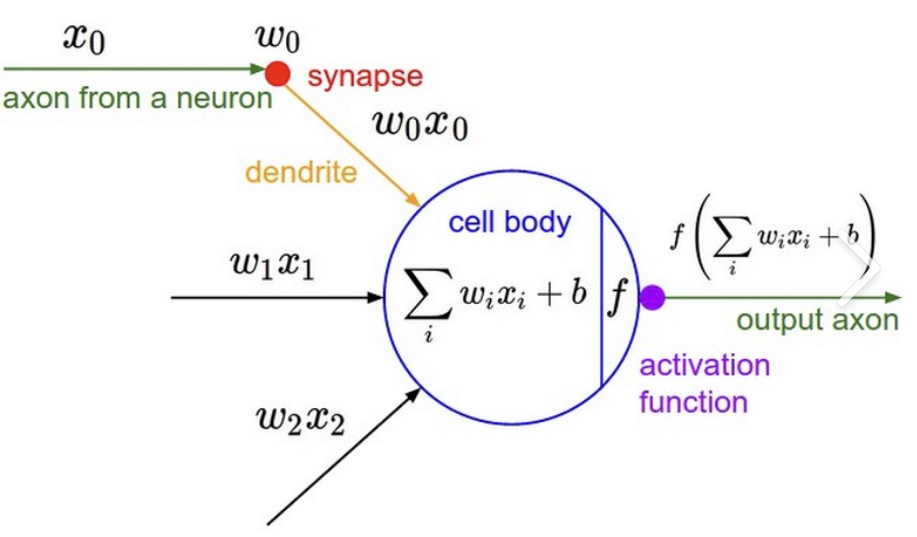

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2    
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

### 1. _backward()自动更新梯度

In [7]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()  # 叶子结点，无作用
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

### 2. 手动计算梯度

In [8]:
o.grad = 1.0
n.grad = 0.5 # do/dn = 1 - tanh(n)**2 = 1 - o**2 = 1 - o.data**2 = 0.499999999

x1w1x2w2.grad = 0.5 # '+'最好计算
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad  # '*'梯度等于另一边的值
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad


### 3. 使用显式的backward函数自动计算梯度

In [6]:
o.backward()

### 注：这里的grad都是对于最终变量的

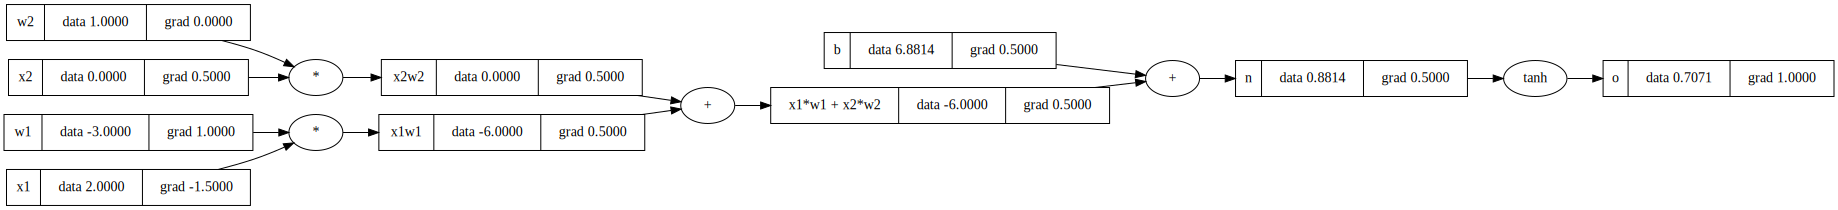

In [7]:
draw_dot(o)

### 更复杂一点的例子

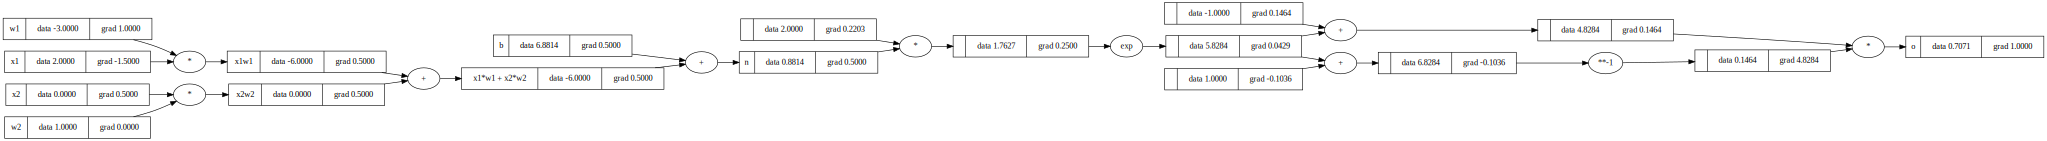

In [8]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2    
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------------
e = (2*n).exp()
o = (e-1) / (e+1)
# ------------

o.label = 'o'
o.backward()
draw_dot(o)

## 使用pytorch实现上面的功能

In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double();  x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double();  w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad_(True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## 定义MLP

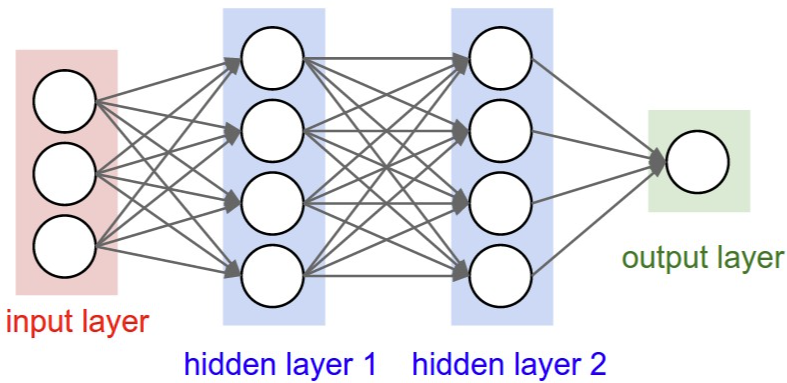

In [20]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # 有几个输入此neuron的数，就有几个w
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):  # 例如 n = Neuron(2)  -->  n(x)即调用此函数
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):  # nouts代表MLP的层数
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [29]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])  
n(x)

Value(data=-0.7669678728113939)

In [30]:
len(n.parameters())  # MLP所有的权重

41

In [31]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, 1.0]
]  # 4个样例输入

ys = [1.0, -1.0, -1.0, 1.0]  # 4个目标输出
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.7669678728113939),
 Value(data=-0.7815669111922536),
 Value(data=-0.7030830116593071),
 Value(data=-0.7031434085900297)]

In [35]:
for k in range(20):

    # forward pass (1. 计算损失)
    ypred = [n(x) for x in xs]
    loss = sum((ypredi - y)**2 for y, ypredi in zip(ys, ypred))

    # backward pass （2. 反向传播）
    for p in n.parameters():  # 记得梯度清零，否则会叠加
        p.grad = 0.0

    loss.backward()

    # update weights  （3. 参数更新）
    for p in n.parameters():         # 梯度是正数：说明如果增加值，会导致loss增加，所以要朝梯度负方向即减小值才能减小loss
        p.data += -0.01 * p.grad     # 梯度是负数：说明如果增加值，会导致loss减小，所以要朝梯度正方向即增加值才能减小loss
    
    print(k, loss.data)

0 0.8984043981437837
1 0.88014175190098
2 0.8622772589755636
3 0.844801001719667
4 0.8277037974254768
5 0.8109770952953006
6 0.794612886191306
7 0.7786036237593744
8 0.7629421556800811
9 0.7476216639372384
10 0.7326356131140594
11 0.7179777058315112
12 0.7036418445351246
13 0.6896220989173798
14 0.6759126783343691
15 0.6625079086391892
16 0.6494022129114335
17 0.6365900956133532
18 0.6240661297493237
19 0.6118249466470282
